# 1. What GBM does

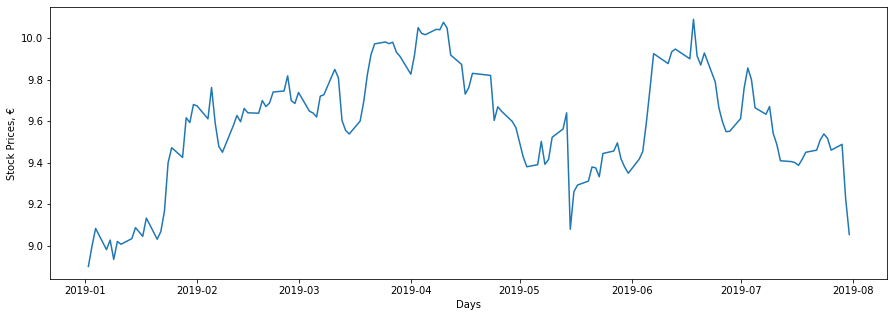

In [4]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot of E.ON(a big scale energy company in Europe) 
# stock prices since beginning of 2019 (up to July)

prices = quandl.get("FSE/EON_X", 
                authtoken="JszJr6jLXCJsPihh_HYi", 
                start_date = '2019-01-01', end_date = '2019-07-31'
                ).reset_index(drop = False)[['Date', 'Close']]
                
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

# 2. What input parameters we need for GBM simulation

In [5]:
# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in the prediction time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

In [7]:
start_date = '2019-07-01'
end_date = '2019-07-31'
pred_end_date = '2019-08-31'

# We get daily closing stock prices of E.ON for July 2019
S_eon = quandl.get("FSE/EON_X", 
               authtoken="JszJr6jLXCJsPihh_HYi", 
               start_date = start_date, end_date = end_date
               ).reset_index(drop = False)[['Date', 'Close']]
               
print(S_eon.head())
print(S_eon.tail())

        Date  Close
0 2019-07-01  9.612
1 2019-07-02  9.761
2 2019-07-03  9.856
3 2019-07-04  9.800
4 2019-07-05  9.664
         Date  Close
18 2019-07-25  9.517
19 2019-07-26  9.460
20 2019-07-29  9.488
21 2019-07-30  9.226
22 2019-07-31  9.054


### 1. S0

In [8]:
S0 = S_eon.loc[S_eon.shape[0] - 1, "Close"]
print(S0)

9.054


### 2. dt

In [9]:
dt = 1
print(dt)

1


### 3. T

In [10]:
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
              format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
              end = pd.to_datetime(pred_end_date, 
              format = "%Y-%m-%d")).to_series(
              ).map(lambda x: 
              1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays
print(T)

22


### 4. N

In [11]:
N = T / dt
print(N)

22.0


### 5. t

In [12]:
t = np.arange(1, int(N) + 1)
print(t)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


### 6. mu

$$r_k=\frac{S_k-S_{k-1}}{S_{k-1}}, \forall k.$$

In [13]:
returns = (S_eon.loc[1:, 'Close'] - \
          S_eon.shift(1).loc[1:, 'Close']) / \
          S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())

[0.015501456512692377, 0.00973260936379476, -0.005681818181818097, -0.013877551020408265, -0.0032077814569537026, 0.00384096335513348, -0.013340227507755901, -0.005554973273241884, -0.008326306913996506, -0.0004251248804337693, -0.0005316321105793732, -0.0013829787234042447, 0.0030893789283050936, 0.0036108751062020944, 0.0010582010582012237, 0.0052854122621563355, 0.002944269190326022, -0.0022017194380374075, -0.0059892823368707165, 0.0029598308668074727, -0.0276138279932545, -0.018642965532191694]


$$\mu=\frac{1}{|k|}\sum_kr_k.$$

In [14]:
mu = np.mean(returns)
print(mu)

-0.0026705996693330543


### 7. sigma

$$\sigma=\sqrt{\frac{1}{|k|}\sum_k(r_k-\mu)^2}.$$

In [15]:
sigma = np.std(returns)
print(sigma)

0.009362443851856311


### 8. b

The important thing here is the scen_size variable. Since this is a simulation model, we want to have many hypothetical paths for the stock price within the prediction time horizon. Assigning 2 to scen_size means, in the end, we will have 2 different stock price series.

Here array b, for each corresponding prediction time point, stores a random number coming from the standard normal distribution.

In [16]:
scen_size = 2
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
print(b)

{'1': array([-0.45449398,  0.78731033,  1.93137495, -0.45021043,  0.21107118,
       -0.86554098,  1.65943944,  0.8364143 , -0.42519793,  1.53072531,
       -1.1130669 ,  0.87219831,  0.47034311,  2.81860397,  2.2282037 ,
       -2.05906316, -0.7933374 , -0.43318878,  0.9856738 ,  1.49143293,
       -0.0746326 , -0.91701778]), '2': array([-7.03500016e-01, -1.24144872e+00, -2.95462007e-01, -2.71952003e+00,
       -7.73961452e-01,  1.29841709e-01, -1.46841904e+00, -8.61158165e-01,
       -2.72612625e-01,  1.83637564e-01,  2.26634988e+00, -1.71870337e+00,
        2.16766847e+00, -5.44399948e-02, -1.25743375e+00, -9.75288496e-01,
       -5.61388237e-01,  1.76490735e+00, -7.43578529e-04,  4.58330763e-01,
       -2.73043460e-01,  6.47440853e-01])}


### 9. W

b is the random shock being applied to the stock price at a time point when predicting the stock price of the NEXT time point. So, suppose, at time point 3, the stock price is S_3. When predicting time point 4, b(4) is applied to S_3 as the random shock. W, on the other hand, is THE PATH. It means that it includes the effects of all the random shocks since the beginning of the prediction time horizon. It is the total effect of randomness incorporated into So(initial stock price) until the specific time point we are concerned with. So, suppose, we are predicting time point 4. We need to apply all the random shocks up-to and including time point 4 to So. Therefore, instead of b(4), we use W(4) which is the cumulative sum of array b elements with index less than or equal to 4. 

$$W_k=\sum_{i\leq k} b_i, \ k=1,\dots,N.$$

In [17]:
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
print(W)

{'1': array([-0.45449398,  0.33281636,  2.26419131,  1.81398088,  2.02505206,
        1.15951107,  2.81895051,  3.65536481,  3.23016688,  4.76089219,
        3.64782529,  4.5200236 ,  4.99036671,  7.80897068, 10.03717438,
        7.97811122,  7.18477382,  6.75158504,  7.73725884,  9.22869177,
        9.15405917,  8.23704139]), '2': array([-0.70350002, -1.94494873, -2.24041074, -4.95993077, -5.73389222,
       -5.60405052, -7.07246955, -7.93362772, -8.20624034, -8.02260278,
       -5.7562529 , -7.47495628, -5.30728781, -5.3617278 , -6.61916155,
       -7.59445005, -8.15583828, -6.39093093, -6.39167451, -5.93334374,
       -6.2063872 , -5.55894635])}


# 3. The components of GBM: Drift and Diffusion

**Assumption 1**: length of the time period between (k-1) and (k), which is dt, is in line with the historical data frequency.

**Assumption 2**: the time in our simulation progresses through counting time periods.

### 1. Drift

$$drift_k=\mu-\frac{1}{2}\sigma^2 \longrightarrow S_k=S_{k-1}e^{drift_k}=S_{k-1}e^{\mu-\frac{1}{2}\sigma^2}.$$

### 2. Diffusion

$$diffusion_k=\sigma b_k=\sigma z_k.$$

$$S_k=S_{k-1}e^{drift_k+diffusion_k}=S_{k-1}e^{\mu-\frac{1}{2}\sigma^2+\sigma z_k}.$$

# 4. Building the discrete-time GBM model

$$S_k=S_0\prod_i^ke^{\mu-\frac{1}{2}\sigma^2+\sigma z_i}, \ k=1,\dots,N.$$

$$S_k=S_0e^{\left(\mu-\frac{1}{2}\sigma^2\right)k+\sigma \sum_i^kb_i}=S_0e^{\left(\mu-\frac{1}{2}\sigma^2\right)t_k+\sigma W_k}.$$

Above is the penultimate equation for S(k). It means, we can predict S(k) from So by adding the combined effect of k many drifts and the cumulative diffusion up to k. 

# 5. Making predictions

In [21]:
drift = (mu - 0.5 * sigma**2) * t
print("drift:\n", drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print("diffusion:\n", diffusion)

drift:
 [-0.00271443 -0.00542885 -0.00814328 -0.01085771 -0.01357214 -0.01628656
 -0.01900099 -0.02171542 -0.02442985 -0.02714427 -0.0298587  -0.03257313
 -0.03528756 -0.03800198 -0.04071641 -0.04343084 -0.04614526 -0.04885969
 -0.05157412 -0.05428855 -0.05700297 -0.0597174 ]
diffusion:
 {'1': array([-0.00425517,  0.00311597,  0.02119836,  0.01698329,  0.01895944,
        0.01085586,  0.02639227,  0.03422315,  0.03024226,  0.04457359,
        0.03415256,  0.04231847,  0.04672203,  0.07311105,  0.09397248,
        0.07469462,  0.06726704,  0.06321134,  0.07243965,  0.08640311,
        0.08570436,  0.07711884]), '2': array([-0.00658648, -0.01820947, -0.02097572, -0.04643707, -0.05368324,
       -0.05246761, -0.0662156 , -0.07427814, -0.07683046, -0.07511117,
       -0.05389259, -0.06998386, -0.04968918, -0.05019888, -0.06197153,
       -0.07110261, -0.07635858, -0.05983473, -0.05984169, -0.0555506 ,
       -0.05810695, -0.05204532])}


In [23]:
S = np.array([S0 * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[S0] for scen in range(scen_size)]), S))
print(S)

[[9.054      8.99111662 9.03308338 9.17297564 9.10963126 9.10290823
  9.00496365 9.12116852 9.16795616 9.1067788  9.21318823 9.09296018
  9.14266564 9.15812187 9.37752356 9.54925098 9.34153354 9.24727049
  9.18487668 9.24490123 9.34948452 9.31762753 9.21293141]
 [9.054      8.97018    8.84248832 8.79415809 8.54983399 8.46509525
  8.45241734 8.31440921 8.22528615 8.18207952 8.17394133 8.3266012
  8.17147689 8.31640366 8.28963377 8.17040689 8.07419521 8.01009648
  8.12147855 8.09940689 8.11218705 8.06954197 8.0965976 ]]


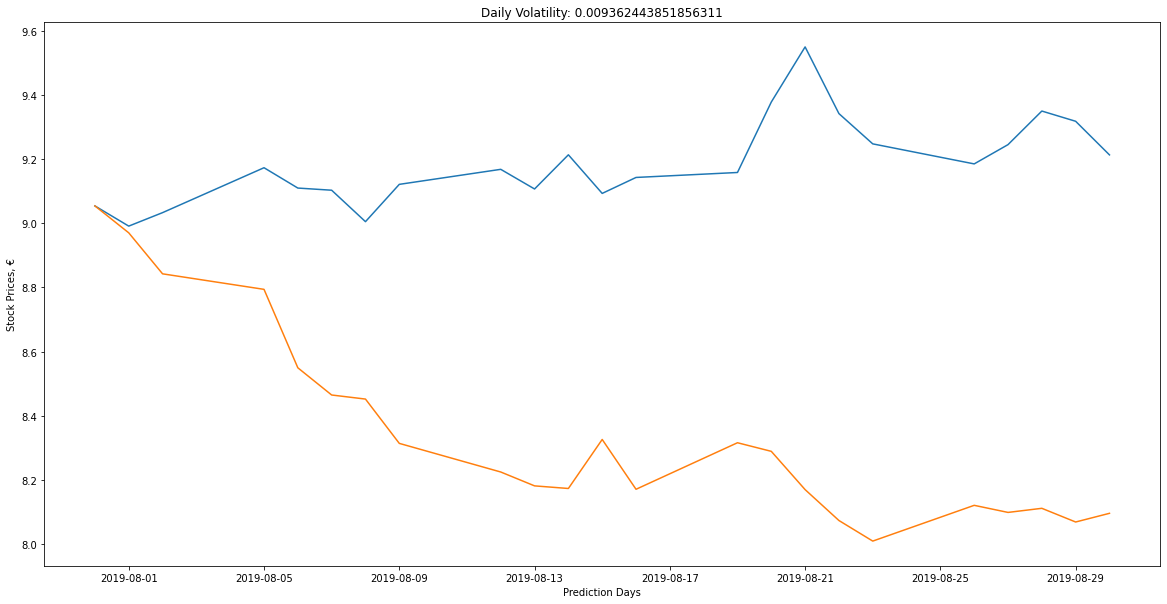

In [24]:
# Plotting the simulations
plt.figure(figsize = (20,10))

for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = S_eon["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
    
plt.show()